In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import dataset
assert tf.config.list_physical_devices('GPU')


['', 'H', 'O', '5', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'ך', 'כ', 'ל', 'ם', 'מ', 'ן', 'נ', 'ס', 'ע', 'ף', 'פ', 'ץ', 'צ', 'ק', 'ר', 'ש', 'ת']


Using TensorFlow backend.


In [19]:
MAXLEN = 32
BATCH_SIZE = 32

EMBED_DIM = 512
UNITS = 256

NIQQUD_SIZE = len(dataset.niqqud_table)
DAGESH_SIZE = len(dataset.dagesh_table)
LETTERS_SIZE = len(dataset.letters_table)

common_input = tf.keras.Input(batch_shape=(None, MAXLEN), batch_size=BATCH_SIZE)
common = layers.Embedding(LETTERS_SIZE, EMBED_DIM, mask_zero=True)(common_input)
common = layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)

common = layers.add([common, layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)])

niqqud = layers.Softmax(name='N')(layers.Dense(NIQQUD_SIZE)(common))
dagesh = layers.Softmax(name='D')(layers.Dense(DAGESH_SIZE)(common))

model = tf.keras.Model(inputs=[common_input], outputs=[niqqud, dagesh])

tf.keras.utils.plot_model(model, to_file='model.png')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

def fit(data, learning_rates):
    return model.fit(data.normalized_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=len(learning_rates),
          validation_data=(data.normalized_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: learning_rates[epoch], verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 512)      22016       input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 32, 256)      1574912     embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 32, 256)      1050624     bidirectional_6[0][0]            
______

In [9]:
rabanit = ['birkat_hamazon.txt', 'hakdama_leorot.txt', 'hartzaat_harav.txt', 'orhot_hayim.txt', 'rambam_mamre.txt', 'short_table.txt', 'tomer_dvora.txt', 'breslev.txt']
modern = ['atar_hashabat.txt', 'kakun.txt', 'sisters.txt', 'treasure_island.txt', 'ali_baba.txt', 'people.txt', 'ricky.txt', 'imagination.txt', 'adamtsair.txt', 'katarsis.txt']
def load_data(source):
    filenames = ['texts/' + f for f in source]
    return dataset.load_file(filenames, BATCH_SIZE, 0.01, maxlen=MAXLEN, shuffle=True)


In [20]:
history = fit(load_data(rabanit), [2e-3])  # , 2e-4
model.save_weights('./checkpoint_rabanit')

Train on 178643 samples, validate on 1805 samples
178643/178643 [==============================] - 155s 867us/sample - loss: 0.2079 - N_loss: 0.1649 - D_loss: 0.0430 - N_accuracy: 0.9398 - D_accuracy: 0.9829 - val_loss: 0.1245 - val_N_loss: 0.0959 - val_D_loss: 0.0286 - val_N_accuracy: 0.9656 - val_D_accuracy: 0.9890


In [43]:
model.load_weights('./checkpoint_rabanit')
# 1.00e-3: val_N_accuracy: 0.9533 - val_D_accuracy: 0.9786
# 1.50e-3: val_N_accuracy: 0.9535 - val_D_accuracy: 0.9823
# 1.75e-3: val_N_accuracy: 0.9579 - val_D_accuracy: 0.9839
# 1.80e-3: val_N_accuracy: 0.9631 - val_D_accuracy: 0.9850
# 1.85e-3: val_N_accuracy: 0.9480 - val_D_accuracy: 0.9802 
# 2.00e-3: val_N_accuracy: 0.9511 - val_D_accuracy: 0.9821
# 3.00e-3: val_N_accuracy: 0.9517 - val_D_accuracy: 0.9799
history = fit(load_data(modern), [1.80e-3])

Train on 16758 samples, validate on 170 samples
16758/16758 [==============================] - 13s 783us/sample - loss: 0.2161 - N_loss: 0.1677 - D_loss: 0.0484 - N_accuracy: 0.9431 - D_accuracy: 0.9792 - val_loss: 0.1571 - val_N_loss: 0.1151 - val_D_loss: 0.0365 - val_N_accuracy: 0.9631 - val_D_accuracy: 0.9850_loss: 0.1780 - D_loss: 


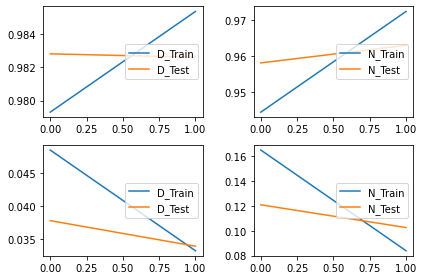

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [45]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '.')

In [44]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.normalized_validation[s]
    prediction = model.predict(batch)
    [actual_niqqud, actual_dagesh] = [dataset.from_categorical(prediction[0]), dataset.from_categorical(prediction[1])]
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        print()

print_predictions(1)

מצוי:  הַחַלוֹן שֶהִקִיף פְּנִימָה. הוּא רָאָה אֶת
רצוי:  הַחַלּוֹן שֶהִקִּיף פְּנִימָה. הוּא רָאָה אֶת

מצוי:  טְרִילוֹנֵי. "אֵין זֶה מְשַנֶה עַכְשָו מִי
רצוי:  טְרִילוֹנִי. "אֵין זֶה מְשַנֶה עַכְשָו מִי

מצוי:  אַחַת גְּדוֹלָה. הַשְטֶרְלִינְגִים הָיוּ מְעַטִים
רצוי:  אַחַת גְדוֹלָה. הַשְטֶרְלִינְגִים הָיוּ מֻעָטִים

מצוי:  וְהַשֵד-יוֹדֵעַ מָה עוֹד - הַכֹּל בְּעִרְבּוּבֶיָה
רצוי:  וְהַשֵד-יוֹדֵעַ מָה עוֹד - הַכֹּל בְּעִרְבּוּבְיָה

מצוי:  מַתְאִים לִי; זֶהוּ מָתַי. הַמַזָל הֵבִיא
רצוי:  מַתְאִים לִי; זֶהוּ מָתַי. הַמַזָל הֵבִיא

מצוי:  אַחַת לְיַד הַשְנִיָּה. כְּשֶהִגִיעַ הַלַיְלָה הָיָה
רצוי:  אַחַת לְיַד הַשְנִיָה. כְּשֶהִגִיעַ הַלַיְלָה הָיָה

מצוי:  הִתְרַשַמְתִּי מְאוֹד מֵהַכַּוֶרֶת וּמְאוֹד אָהַבְתִּי
רצוי:  הִתְרַשַּמְתִּי מְאוֹד מֵהַכַּוֶּרֶת וּמְאוֹד אָהַבְתִּי

מצוי:  לְסִיבוּב בַּשְכוּנָה כְּדֵי לְחַפֵּש בַּקְבּוּקִים
רצוי:  לְסִיבוּב בַּשְכוּנָה כְּדֵי לְחַפֵּש בַּקְבּוּקִים

מצוי:  מְנוּחָה. כָּל הַמִתְעַנְגִים בָּהּ יִזְכּוּ לְרַב
רצוי:  מְנוּחָה. כָּל הַמִּתְעַנְּגִים ב

In [8]:
print(dataset.niqqud_table.chars)

['', 'ְ', 'ֱ', 'ֲ', 'ֳ', 'ִ', 'ֵ', 'ֶ', 'ַ', 'ָ', 'ֹ', 'ֺ', 'ֻ', 'ּ', 'ַ']
